In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import linear_sum_assignment
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
# Load data
loaded_df = pd.read_hdf('../data/sample_otu_arrays.h5', key='df')

# Set random seed
np.random.seed(42)

# Split indices into train/test
train_idx, test_idx = train_test_split(loaded_df.index, test_size=0.2, random_state=42)

# Create train and test dataframes
train_df = loaded_df.loc[train_idx]
test_df = loaded_df.loc[test_idx]

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print("\nFirst few training samples:")
print(train_df.head())

# Let's also look at array lengths
array_lengths = [len(x) for x in loaded_df['otu_arrays']]
print(f"\nMin array length: {min(array_lengths)}")
print(f"Max array length: {max(array_lengths)}")
print(f"Mean array length: {np.mean(array_lengths):.2f}")

Train size: 6486
Test size: 1622

First few training samples:
                                                            otu_arrays
Unnamed: 0                                                            
SRR044975.SRS011167  [30, 58, 82, 89, 93, 98, 99, 104, 117, 120, 12...
SRR049604.SRS049164  [9, 10, 11, 14, 15, 16, 17, 20, 28, 30, 31, 32...
SRR331714.SRS076947  [19, 30, 43, 58, 65, 70, 71, 74, 80, 90, 92, 9...
SRR089999.SRS077685  [12, 14, 18, 20, 22, 38, 45, 67, 68, 76, 88, 1...
SRR048091.SRS021563  [19, 30, 45, 52, 58, 60, 65, 70, 74, 80, 90, 9...

Min array length: 3
Max array length: 277
Mean array length: 69.10


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class OTUDataset(Dataset):
    def __init__(self, df, pad_token_id=0):
        self.df = df
        self.pad_token_id = pad_token_id
        
        # Find max sequence length for padding
        self.max_len = max(len(x) for x in df['otu_arrays'])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        array = self.df.iloc[idx]['otu_arrays']
        
        # Create padded sequence
        padded = torch.full((self.max_len,), self.pad_token_id, dtype=torch.long)
        padded[:len(array)] = torch.tensor(array, dtype=torch.long)
        
        # Create padding mask (False for real tokens, True for padding)
        # This matches the convention used in transformers where
        # True indicates positions that should be masked
        padding_mask = torch.zeros(self.max_len, dtype=torch.bool)
        padding_mask[len(array):] = True
        
        return {
            'input_ids': padded,
            'padding_mask': padding_mask,
            'seq_len': len(array)
        }

# Create datasets
train_dataset = OTUDataset(train_df, pad_token_id=0)
test_dataset = OTUDataset(test_df, pad_token_id=0)

# Create dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify shapes
for i in train_loader:
   print(i['input_ids'].shape)
   print(i['padding_mask'].shape)
   print(i['seq_len'])
   break

# Get vocab size (maximum token ID + 1 for padding)
vocab_size = max(max(x) for x in loaded_df['otu_arrays']) + 1
print(f"\nVocabulary size: {vocab_size}")

torch.Size([8, 277])
torch.Size([8, 277])
tensor([ 63,  45,  44,  29,  61,  67, 108,  22])

Vocabulary size: 519


In [4]:
import importlib
import cdcdModel
import scheduler
importlib.reload(cdcdModel)
importlib.reload(scheduler)

from cdcdModel import CDCDModel
from scheduler import AdaptiveSchedule

In [47]:
def train_step(model, batch, scheduler, optimizer):
    """Single training step for CDCD model
    
    Args:
        model: CDCDModel instance
        batch: Dictionary containing:
            - input_ids: [batch_size, seq_len] tensor of token ids
            - padding_mask: [batch_size, seq_len] boolean tensor (True for padding)
        scheduler: AdaptiveSchedule instance
        optimizer: PyTorch optimizer
    
    Returns:
        loss: scalar training loss
        entropy: entropy statistics for scheduler
    """
    # Get batch data
    input_ids = batch['input_ids']
    padding_mask = batch['padding_mask']
    batch_size, seq_len = input_ids.shape
    
    # Sample random timesteps for training
    timesteps = scheduler.sample((batch_size,)).to(input_ids.device)  # Shape: [batch_size]
   
    
    # Forward pass through model
    logits = model(
        input_ids,
        timesteps=timesteps,
        training=True,
        padding_mask=padding_mask
    )
    
    # Calculate cross entropy loss (ignoring padding)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # Assuming 0 is pad_token_id
    loss = loss_fn(
        logits.view(-1, logits.size(-1)),
        input_ids.view(-1)
    )
    
    # Calculate entropy for scheduler
    with torch.no_grad():
        probs = F.softmax(logits, dim=-1)
        
        # Add small epsilon to prevent log(0)
        eps = 1e-8
        probs = torch.clamp(probs, min=eps, max=1-eps)
        
        entropy = -(probs * torch.log(probs)).sum(dim=-1)  # [batch_size, seq_len]
        
        # Expand timesteps to match sequence dimension
        timesteps_expanded = timesteps.unsqueeze(-1).expand(-1, seq_len)
        
        # Add entropy data to scheduler (excluding padding)
        scheduler.add_data(
            entropy[~padding_mask],
            timesteps_expanded[~padding_mask],
            padding_mask=None  # Already filtered padding
        )
    
    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item(), entropy.mean().item()

In [48]:
def run_epoch(model, dataloader, scheduler, optimizer, train_run=True, epoch_num=None):
   """Runs one epoch of training or evaluation for the CDCD model
   
   Args:
       model: CDCDModel instance
       dataloader: PyTorch DataLoader containing batches
       scheduler: AdaptiveSchedule instance
       optimizer: PyTorch optimizer
       train_run: bool, whether to run in training mode or eval mode
       epoch_num: Optional int, current epoch number for logging
   
   Returns:
       dict containing metrics:
           - loss: average loss over the epoch
           - entropy: average entropy over the epoch
           - num_batches: number of batches processed
   """
   model.train() if train_run else model.eval()
   total_loss = 0
   total_entropy = 0
   num_batches = 0
   
   # Setup progress bar
   mode = "Train" if train_run else "Eval"
   epoch_str = f"Epoch {epoch_num}" if epoch_num is not None else mode
   pbar = tqdm(total=len(dataloader), desc=f"{epoch_str} Loss: 0.0000, Entropy: 0.0000")
   device = next(model.parameters()).device

   # Main loop
   for batch in dataloader:
       # Move batch to device
       batch = {k: v.to(device) for k, v in batch.items()}
       
       if train_run:
           loss, entropy = train_step(model, batch, scheduler, optimizer)
       else:
           with torch.no_grad():
               loss, entropy = train_step(model, batch, scheduler, optimizer)
       
       # Accumulate metrics
       total_loss += loss
       total_entropy += entropy
       num_batches += 1
       
       # Update progress bar
       avg_loss = total_loss / num_batches
       avg_entropy = total_entropy / num_batches
       pbar.set_description(f"{epoch_str} Loss: {avg_loss:.4f}, Entropy: {avg_entropy:.4f}")
       pbar.update(1)
   
   pbar.close()
   
   # Calculate final averages
   avg_loss = total_loss / num_batches
   avg_entropy = total_entropy / num_batches
   
   # Update scheduler parameters if training
   if train_run:
       scheduler.update_optimal_parameters(history=10_000)
   
   # Log final metrics
   mode_str = "Train" if train_run else "Eval"
   epoch_str = f"Epoch {epoch_num} " if epoch_num is not None else ""
   
   
   return {
       "loss": avg_loss,
       "entropy": avg_entropy,
       "num_batches": num_batches
   }

In [49]:
# Model hyperparameters
hidden_dim = 32  # Dimension of hidden layers
embedding_dim = 32  # Dimension of embeddings
num_heads = 8  # Number of attention heads
num_layers = 4  # Number of transformer layers
time_embed_dim = 32  # Dimension of time embeddings
t_min = 1 # Minimum time value
t_max = 25  # To high breaks scheduler. This value really depends on embed dim: SNR = ed/t^2. if ed = 32, tmax=25 ~ 0 SNR
vocab_size = 519

model = CDCDModel(
    hidden_dim = hidden_dim,
    embedding_dim = embedding_dim,
    num_heads = num_heads,
    num_layers = num_layers,
    time_embed_dim = time_embed_dim,
    t_min = t_min,
    t_max = t_max,
    vocab_size = vocab_size
)

scheduler = AdaptiveSchedule(
    tmin = t_min,
    tmax = t_max,
    mu = 150,
    sigma = 50,
    height = 1,
    offset = 0.1
)

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [51]:
for i in range(20):
    run_epoch(model, train_loader, scheduler, optimizer, train_run = True, epoch_num = i)

Epoch 0 Loss: 5.7187, Entropy: 6.0879: 100%|██████████| 811/811 [00:17<00:00, 45.49it/s]
2025-02-11 11:21:24,067 - INFO - Updated optimal parameters: mu=1159.825048589814, sigma=296.53101262214244, height=70.61797341741473, offset=-0.10241564871592908
Epoch 1 Loss: 5.6199, Entropy: 6.0530: 100%|██████████| 811/811 [00:16<00:00, 49.72it/s]
2025-02-11 11:21:40,456 - INFO - Updated optimal parameters: mu=964.4639731456382, sigma=683.4212133826505, height=56.207491275993775, offset=-5.626495031565827
Epoch 2 Loss: 5.5523, Entropy: 6.0197: 100%|██████████| 811/811 [00:18<00:00, 43.66it/s]
2025-02-11 11:21:59,373 - INFO - Updated optimal parameters: mu=0.7800374813203423, sigma=0.5311023350633666, height=16.80200101371358, offset=-11.029616953445649
Epoch 3 Loss: 2.1781, Entropy: 5.1504: 100%|██████████| 811/811 [00:18<00:00, 44.30it/s]
2025-02-11 11:22:17,708 - INFO - Updated optimal parameters: mu=2.029767324234178, sigma=1.103961744268766, height=7.4566058379977305, offset=-1.698523426215

In [52]:
print(f"Number of time points: {len(scheduler.times)}")
print(f"Number of entropy points: {len(scheduler.entropy)}")
print(f"Number of parameter sets: {len(scheduler.parameters_history)}")
if len(scheduler.times) > 0:
    print(f"Time range: {min(scheduler.times)} to {max(scheduler.times)}")
if len(scheduler.entropy) > 0:
    print(f"Entropy range: {min(scheduler.entropy)} to {max(scheduler.entropy)}")

Number of time points: 8970160
Number of entropy points: 8970160
Number of parameter sets: 21
Time range: 1.000022053718567 to 49.9981689453125
Entropy range: 9.541912731947377e-05 to 6.235629081726074


Text(0, 0.5, 'Density')

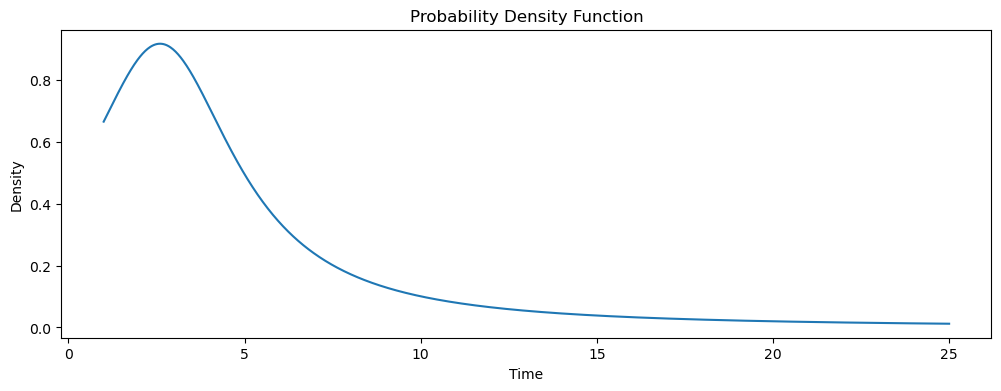

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu = 2.6
sigma = 2.6
height = 7.5
offset = -2

# Create time points
t = np.linspace(1, 25, 1000)

# Calculate PDF (derivative of CDF)
pdf = (height / (np.pi * sigma)) * (1 / (1 + ((t - mu)/sigma)**2))

# Plot PDF
plt.figure(figsize=(12, 4))
plt.plot(t, pdf)
plt.title('Probability Density Function')
plt.xlabel('Time')
plt.ylabel('Density')


Text(0.02, 0.98, 'Points shown: 10,000\nEntropy range: 0.000 to 6.010')

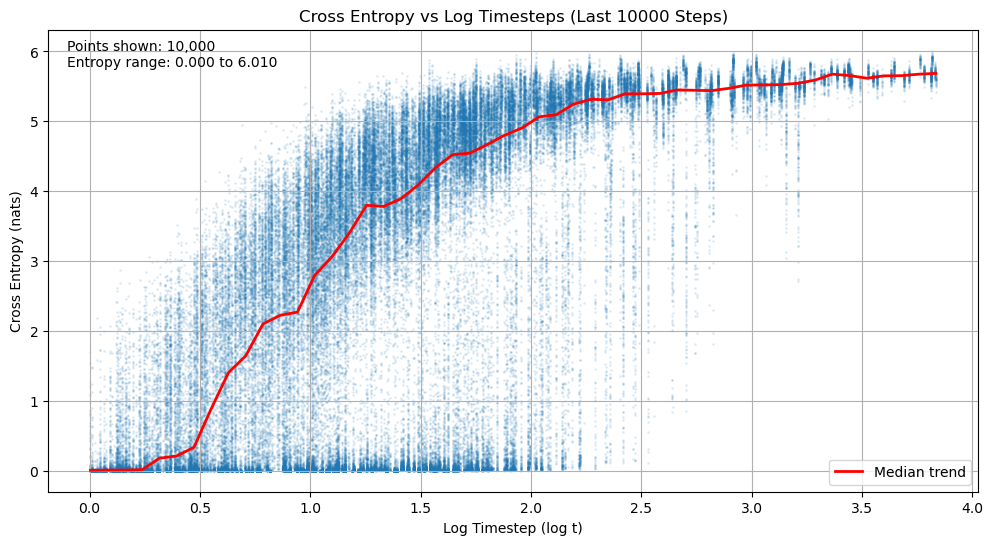

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Get last 10000 points
times = np.array(scheduler.times[-100000:])
entropy = np.array(scheduler.entropy[-100000:])

plt.figure(figsize=(12, 6))
plt.scatter(np.log(times), entropy, alpha=0.1, s=1)

# Trend line using log time bins
log_time_bins = np.linspace(np.log(times.min()), np.log(times.max()), 50)
entropy_means = [np.median(entropy[np.abs(np.log(times) - t) < (np.log(times.max())-np.log(times.min()))/50]) for t in log_time_bins]
plt.plot(log_time_bins, entropy_means, 'r-', linewidth=2, label='Median trend')

plt.title('Cross Entropy vs Log Timesteps (Last 10000 Steps)')
plt.xlabel('Log Timestep (log t)')
plt.ylabel('Cross Entropy (nats)')
plt.grid(True)
plt.legend()

plt.text(0.02, 0.98, f'Points shown: 10,000\nEntropy range: {entropy.min():.3f} to {entropy.max():.3f}', 
        transform=plt.gca().transAxes, verticalalignment='top')

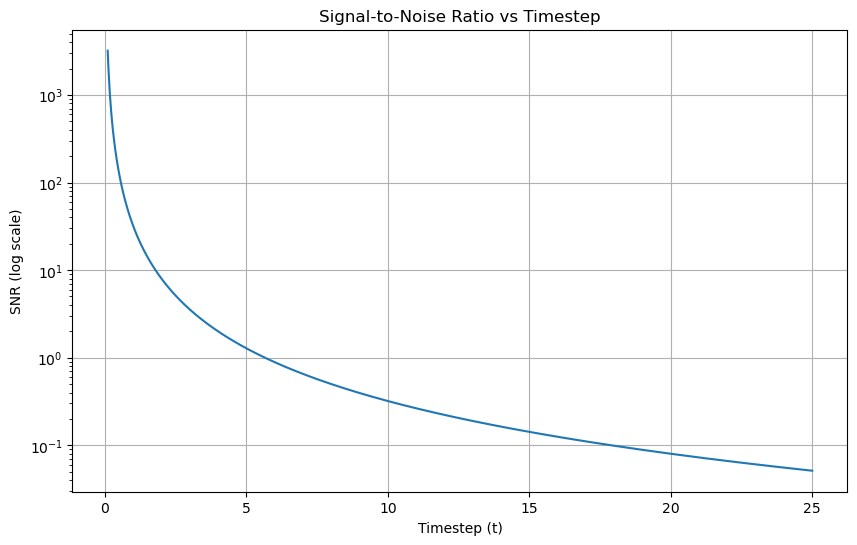

In [65]:
import numpy as np
import matplotlib.pyplot as plt

embed_dim = 32  # typical embedding dimension
t = np.linspace(0.1, 25, 1000)
snr = embed_dim/(t**2)

plt.figure(figsize=(10, 6))
plt.plot(t, snr)
plt.yscale('log')
plt.title('Signal-to-Noise Ratio vs Timestep')
plt.xlabel('Timestep (t)')
plt.ylabel('SNR (log scale)')
plt.grid(True)
plt.show()